In [1]:
#Import 
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Hyperparameters
f = [16, 32, 64, 128, 256] #number of filters for each layer
    #The number of filters is the number of neurons, since each neuron performs a different convolution on the input 
    #to the layer (more precisely, the neurons' input weights form convolution kernels).
    #A feature map is the result of applying a filter (thus, you have as many feature maps as filters), 
    #and its size is a result of window/kernel size of your filter and stride.
img_size = 128
batch_size = 8
    #The batch size defines the number of samples that will be propagated through the network.
    #For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.
    #Advantages of using a batch size < number of all samples: 
    #It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.
    #Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.
    #Disadvantages of using a batch size < number of all samples:
    #The smaller the batch the less accurate the estimate of the gradient will be. In the figure below, you can see that the direction of the mini-batch gradient (green color) fluctuates much more in comparison to the direction of the full batch gradient (blue color).
epochs = 30
    #In terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new "unseen" input (test data). An epoch is often mixed up with an iteration. Iterations is the number of batches or steps through partitioned packets of the training data, needed to complete one epoch.  Heuristically, one motivation is that (especially for large but finite training sets) it gives the network a chance to see the previous data to readjust the model parameters so that the model is not biased towards the last few data points during training.  
training_path = "dataset/stage1_train/"
test_path = "dataset/stage1_test/"
training_img_ids = next(os.walk(training_path))[1]
test_img_ids = next(os.walk(test_path))[1]

In [3]:
# Data Loader
class DataLoader(keras.utils.Sequence):
    #batch size because loading all images by once will be to heavy; image size 128 because all images have different sizes and have to be resized.
    def __init__(self, img_ids, path, batch_size = 4, img_size = 128):
        self.img_ids = img_ids
        self.path = path
        self.batch_size = batch_size
        self.img_size=img_size
        self.on_epoch_end()
    
    #function to load the single image and the single mask + all masks for a single image using the ids
    def __load__(self, img_id_name):
        #set paths
        img_path = os.path.join(self.path, img_id_name, "images", img_id_name) + ".png"
        mask_path = os.path.join(self.path, img_id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        #read the images
        img = cv2.imread(img_path, 1) # 1 = read in in color form; 0 would be grey scale
        img = cv2.resize(img, (self.img_size, self.img_size))
        mask = np.zeros((self.img_size, self. img_size, 1))
        
        #read the masks
        for i in all_masks:
            _mask_path = mask_path + i
            _mask_img = cv2.imread(_mask_path, -1)
            _mask_img = cv2. resize(_mask_img, (self.img_size, self.img_size))
            _mask_img = np.expand_dims(_mask_img, axis = -1)
            mask = np.maximum(mask, _mask_img) #maximum value here will be 255 -> so this has to be normalized
        
        #normalization of img and mask
        img=img/255.0
        mask=mask/255.0
        
        return img, mask
    
     #Gets batch at position index. Should return a complete batch Mandatory function for a Sequence
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.img_ids):
            self.batch_size = len(self.img_ids) - index*self.batch_size
        
        files_batch = self.img_ids[index*self.batch_size : (index+1)*self.batch_size]
        
        img = []
        mask  = []
        
        for id_name in files_batch:
            _image, _mask = self.__load__(id_name)
            img.append(_image)
            mask.append(_mask)
            
        img = np.array(img)
        mask  = np.array(mask)
        
        return img, mask
    #returns complete batch as image and mask are arrays containing the images and masks of the actual batch
    
    
    
    #Number of batch in the Sequence. Mandatory function for a Sequence
    def __len__(self):
        return int(np.ceil(len(self.img_ids)/float(self.batch_size)))
    
    
    
     #Method called at the end of every epoch.
    def on_epoch_end(self):
        pass    

In [4]:
def conv_layer(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    conv1 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,padding=padding,activation="relu")
    norm1 = keras.layers.BatchNormalization()
    conv2 = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,padding=padding,activation="relu")
    norm2 = keras.layers.BatchNormalization()
    x = conv1(x)
    x = norm1(x)
    x = conv2(x)
    x = norm2(x)
    return x

def down_conv_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    pool = keras.layers.MaxPool2D((2,2),(2,2))
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    p = pool(x)
    return x,p

def conv_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = keras.layers.Conv2DTranspose(filters//2,kernel_size=(2,2),strides=(2,2))(x)
    return x

def up_conv_block(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    x = conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = keras.layers.Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2))(x)
    return x

def output_layer(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    x = conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(x)
    return x

In [5]:
def UNet():
    inputs = keras.layers.Input((img_size, img_size, 3)) #3 because of rgb
    #downsampling
    p0 = inputs
    print(p0.shape)
    c1, p1 = down_conv_block(p0, f[0],time_steps=0) #16
    print(c1.shape,p1.shape)
    c2, p2 = down_conv_block(p1, f[1],time_steps=0) #32
    print(c2.shape,p2.shape)
    c3, p3 = down_conv_block(p2, f[2],time_steps=0) #64
    print(c3.shape,p3.shape)
    c4, p4 = down_conv_block(p3, f[3],time_steps=0) #128
    print(c4.shape,p4.shape)
    #convolution_block before upsampling
    cn = conv_block(p4, f[4],time_steps=0) #128
    print(cn.shape)
    
    #upsampling
    u1 = up_conv_block(cn, c4, f[3],time_steps=0) #128
    print(cn.shape,c4.shape)
    u2 = up_conv_block(u1, c3, f[2],time_steps=0) #64
    print(u1.shape,c3.shape)
    u3 = up_conv_block(u2, c2, f[1],time_steps=0) #32
    print(u2.shape,c2.shape)
    outputs = output_layer(u3, c1, f[0],time_steps=0) #16
    print(u3.shape,c1.shape)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [6]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) #Configures the model for training.
model.summary()

(None, 128, 128, 3)
(None, 128, 128, 16) (None, 64, 64, 16)
(None, 64, 64, 32) (None, 32, 32, 32)
(None, 32, 32, 64) (None, 16, 16, 64)
(None, 16, 16, 128) (None, 8, 8, 128)
(None, 16, 16, 128)
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 32, 32, 128) (None, 32, 32, 64)
(None, 64, 64, 64) (None, 64, 64, 32)
(None, 128, 128, 32) (None, 128, 128, 16)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None,

In [7]:
#Training: Unet
training_loader = DataLoader(training_img_ids, training_path, img_size=img_size, batch_size=batch_size)
test_loader = DataLoader(test_img_ids, test_path, img_size=img_size, batch_size=batch_size)

train_steps = len(training_img_ids)//batch_size
test_steps = len(test_img_ids)//batch_size

history_unet=model.fit_generator(training_loader, validation_data=test_loader, steps_per_epoch=train_steps, validation_steps=test_steps, 
                    epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
Epoch 1/30
75/75 [==============================] - 200s 3s/step - loss: 2.1661 - acc: 0.7727 - val_loss: 2.3656 - val_acc: 0.8330
Epoch 2/30
75/75 [==============================] - 131s 2s/step - loss: 1.4219 - acc: 0.8141 - val_loss: 0.5815 - val_acc: 0.8799
Epoch 3/30
75/75 [==============================] - 126s 2s/step - loss: 0.6557 - acc: 0.8506 - val_loss: 0.5403 - val_acc: 0.8804
Epoch 4/30
75/75 [==============================] - 128s 2s/step - loss: 0.4776 - acc: 0.8479 - val_loss: 0.4601 - val_acc: 0.8811
Epoch 5/30
75/75 [==============================] - 155s 2s/step - loss: 0.4018 - acc: 0.8577 - val_loss: 0.3799 - val_acc: 0.8888
Epoch 6/30
75/75 [==============================] - 153s 2s/step - loss: 0.3514 - acc: 0.8592 - val_loss: 0.3881 - val_acc: 0.8910
Epoch 7/30
75/75 [=============================

In [12]:
def recurrent_conv_layer(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    x = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,padding=padding)(x)
    norm = keras.layers.BatchNormalization()
    conv_t = keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,padding=padding,activation="relu")
    
    x_t = conv_t(x)#t0
    x_t = norm(x_t)
    for step in range(time_steps):
        x_t = norm(conv_t(keras.layers.Add()([x,x_t])))
    return x_t

def recurrent_down_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    p = keras.layers.MaxPool2D((2,2),(2,2))(x)
    return x,p

def recurrent_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    up = keras.layers.Conv2DTranspose(filters//2,kernel_size=(2,2),strides=(2,2))(x)
    return up

def recurrent_up_block(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    x = recurrent_conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    up = keras.layers.Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2))(x)
    return up

def recurrent_output_layer(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    x = recurrent_conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    outs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(x)
    return outs

In [13]:
#f = [16, 32, 64, 128, 256] #number of filters for each layer

#RUNet Model as described in Fig. 3 https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
def RUNet():
    inputs = keras.layers.Input((img_size, img_size, 3)) #3 because of rgb
    #inputs = tf.random.normal((1,224,224,3))
    #downsampling
    p0 = inputs
    print(p0.shape)
    c1, p1 = recurrent_down_block(p0, f[0]) #16
    print(c1.shape,p1.shape)
    c2, p2 = recurrent_down_block(p1, f[1]) #32
    print(c2.shape,p2.shape)
    c3, p3 = recurrent_down_block(p2, f[2]) #64
    print(c3.shape,p3.shape)
    c4, p4 = recurrent_down_block(p3, f[3]) #128
    print(c4.shape,p4.shape)
    #convolution_block before upsampling
    cn = recurrent_block(p4, f[4]) #128
    print(cn.shape)
    
    #upsampling
    u1 = recurrent_up_block(cn, c4, f[3]) #128
    print(cn.shape,c4.shape)
    u2 = recurrent_up_block(u1, c3, f[2]) #64
    print(u1.shape,c3.shape)
    u3 = recurrent_up_block(u2, c2, f[1]) #32
    print(u2.shape,c2.shape)
    outputs = recurrent_output_layer(u3, c1, f[0]) #16
    print(u3.shape,c1.shape)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [14]:
model = RUNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) #Configures the model for training.
model.summary()

(None, 128, 128, 3)
(None, 128, 128, 16) (None, 64, 64, 16)
(None, 64, 64, 32) (None, 32, 32, 32)
(None, 32, 32, 64) (None, 16, 16, 64)
(None, 16, 16, 128) (None, 8, 8, 128)
(None, 16, 16, 128)
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 32, 32, 128) (None, 32, 32, 64)
(None, 64, 64, 64) (None, 64, 64, 32)
(None, 128, 128, 32) (None, 128, 128, 16)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (Non

In [15]:
#Training: RUnet
training_loader = DataLoader(training_img_ids, training_path, img_size=img_size, batch_size=batch_size)
test_loader = DataLoader(test_img_ids, test_path, img_size=img_size, batch_size=batch_size)

train_steps = len(training_img_ids)//batch_size
test_steps = len(test_img_ids)//batch_size

history_runet=model.fit_generator(training_loader, validation_data=test_loader, steps_per_epoch=train_steps, validation_steps=test_steps, 
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
Epoch 1/30
75/75 [==============================] - 312s 4s/step - loss: 1.8402 - acc: 0.7654 - val_loss: 7.8199 - val_acc: 0.4453
Epoch 2/30
75/75 [==============================] - 264s 4s/step - loss: 0.8829 - acc: 0.8095 - val_loss: 1.1005 - val_acc: 0.8546
Epoch 3/30
75/75 [==============================] - 271s 4s/step - loss: 0.4815 - acc: 0.8388 - val_loss: 0.4947 - val_acc: 0.8584
Epoch 4/30
75/75 [==============================] - 256s 3s/step - loss: 0.3798 - acc: 0.8460 - val_loss: 0.3839 - val_acc: 0.8723
Epoch 5/30
75/75 [==============================] - 251s 3s/step - loss: 0.4302 - acc: 0.8331 - val_loss: 0.3367 - val_acc: 0.8912
Epoch 6/30
75/75 [==============================] - 231s 3s/step - loss: 0.3389 - acc: 0.8471 - val_loss: 0.3194 - val_acc: 0.8836
Epoch 7/30
75/75 [==============================] - 220s 3s/step - loss: 0.3013 - acc: 0.8553 - val_loss: 0.3149 - val_acc:

In [16]:
def residual_recurrent_down_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    r = keras.layers.Conv2D(filters=filters,kernel_size=1,padding="SAME",strides=1,kernel_initializer=tf.constant_initializer())(x)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    c = keras.layers.Add()([r,x])
    p = keras.layers.MaxPool2D((2,2),(2,2))(c)
    return c,p

def residual_recurrent_block(x,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    r = keras.layers.Conv2D(filters,kernel_size=1,padding="SAME",strides=1,kernel_initializer=tf.constant_initializer())(x)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = keras.layers.Add()([r,x])
    up = keras.layers.Conv2DTranspose(filters//2,kernel_size=(2,2),strides=(2,2))(x)
    return up

def residual_recurrent_up_block(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    r = keras.layers.Conv2D(filters,kernel_size=1,padding="SAME",strides=1,kernel_initializer=tf.constant_initializer())(concat)
    x = recurrent_conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    x = keras.layers.Add()([r,x])
    up = keras.layers.Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2))(x)
    return up

def residual_recurrent_output_layer(x,p,filters,kernel_size=3,padding="SAME",strides=1,time_steps=2):
    concat = keras.layers.Concatenate()([x,p])
    x = recurrent_conv_layer(concat,filters,kernel_size,padding,strides,time_steps)
    x = recurrent_conv_layer(x,filters,kernel_size,padding,strides,time_steps)
    outs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(x)
    return outs

In [17]:
def R2UNet():
    inputs = keras.layers.Input((img_size, img_size, 3)) #3 because of rgb
    #inputs = tf.random.normal((1,224,224,3))
    #downsampling
    p0 = inputs
    print(p0.shape)
    c1, p1 = residual_recurrent_down_block(p0, f[0]) #16
    print(c1.shape,p1.shape)
    c2, p2 = residual_recurrent_down_block(p1, f[1]) #32
    print(c2.shape,p2.shape)
    c3, p3 = residual_recurrent_down_block(p2, f[2]) #64
    print(c3.shape,p3.shape)
    c4, p4 = residual_recurrent_down_block(p3, f[3]) #128
    print(c4.shape,p4.shape)
    #convolution_block before upsampling
    cn = residual_recurrent_block(p4, f[4]) #128
    print(cn.shape)
    
    #upsampling
    u1 = residual_recurrent_up_block(cn, c4, f[3]) #128
    print(cn.shape,c4.shape)
    u2 = residual_recurrent_up_block(u1, c3, f[2]) #64
    print(u1.shape,c3.shape)
    u3 = residual_recurrent_up_block(u2, c2, f[1]) #32
    print(u2.shape,c2.shape)
    outputs = residual_recurrent_output_layer(u3, c1, f[0]) #16
    print(u3.shape,c1.shape)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [18]:
model = R2UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"]) #Configures the model for training.
model.summary()

(None, 128, 128, 3)
(None, 128, 128, 16) (None, 64, 64, 16)
(None, 64, 64, 32) (None, 32, 32, 32)
(None, 32, 32, 64) (None, 16, 16, 64)
(None, 16, 16, 128) (None, 8, 8, 128)
(None, 16, 16, 128)
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 32, 32, 128) (None, 32, 32, 64)
(None, 64, 64, 64) (None, 64, 64, 32)
(None, 128, 128, 32) (None, 128, 128, 16)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (Non

In [19]:
#Training: R2Unet
training_loader = DataLoader(training_img_ids, training_path, img_size=img_size, batch_size=batch_size)
test_loader = DataLoader(test_img_ids, test_path, img_size=img_size, batch_size=batch_size)

train_steps = len(training_img_ids)//batch_size
test_steps = len(test_img_ids)//batch_size

history_r2unet=model.fit_generator(training_loader, validation_data=test_loader, steps_per_epoch=train_steps, validation_steps=test_steps, 
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 75 steps, validate for 8 steps
Epoch 1/30
75/75 [==============================] - 274s 4s/step - loss: 1.7848 - acc: 0.7813 - val_loss: 3.5438 - val_acc: 0.7021
Epoch 2/30
75/75 [==============================] - 223s 3s/step - loss: 0.9684 - acc: 0.8289 - val_loss: 2.2735 - val_acc: 0.7204
Epoch 3/30
75/75 [==============================] - 263s 4s/step - loss: 0.5108 - acc: 0.8542 - val_loss: 1.3909 - val_acc: 0.8777
Epoch 4/30
75/75 [==============================] - 264s 4s/step - loss: 0.4396 - acc: 0.8615 - val_loss: 1.5873 - val_acc: 0.8750
Epoch 5/30
75/75 [==============================] - 305s 4s/step - loss: 0.4578 - acc: 0.8663 - val_loss: 1.5128 - val_acc: 0.8774
Epoch 6/30
75/75 [==============================] - 303s 4s/step - loss: 0.3334 - acc: 0.8671 - val_loss: 3.9115 - val_acc: 0.6874
Epoch 7/30
75/75 [==============================] - 322s 4s/step - loss: 0.3233 - acc: 0.8583 - val_loss: 1.1081 - val_acc:

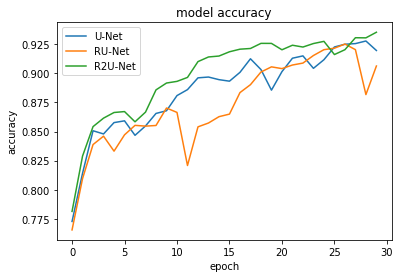

In [23]:
#history_unet
#history_runet
#history_r2unet

plt.plot(history_unet.history['acc'])
plt.plot(history_runet.history['acc'])
plt.plot(history_r2unet.history['acc'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['U-Net', 'RU-Net', 'R2U-Net'], loc='upper left')
plt.show()

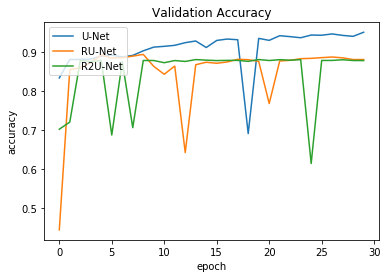

In [24]:
plt.plot(history_unet.history['val_acc'])
plt.plot(history_runet.history['val_acc'])
plt.plot(history_r2unet.history['val_acc'])
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['U-Net', 'RU-Net', 'R2U-Net'], loc='upper left')
plt.show()